# Notebook to select FORS2-SL SED's from their color indices ONLY and use as SED templates for LePhare

Created on : Mar. 7, 2023 by Joseph Chevalier

Last update : Mar. 7, 2023 by Joseph Chevalier

In [1]:
import os, sys, re
import pickle
import json
import glob
import collections
import copy
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.offsetbox
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline
# to enlarge the sizes
params = {'legend.fontsize': 'large',
          'figure.figsize': (12, 8),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

from itertools import cycle, islice

from astropy.io import fits
from astropy.table import Table
from scipy import ndimage
from scipy.interpolate import interp1d
from sklearn.cluster import KMeans


# Import the primary photometry classes from rubin_sim.photUtils
from rubin_sim.phot_utils import Bandpass
from rubin_sim.phot_utils import Sed
from rubin_sim.data import get_data_dir
from StudyFors2SED.def_raw_seds import *
#from StudyFors2SED.raw_data_analysis import *

pysynphot_root_path=os.environ['PYSYN_CDBS']
path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')
# pysynphot
import pysynphot as S
S.refs.setref(area=1)
S.refs.getref()

{'graphtable': '/home/joseph/local/dir/trds/mtab/57g1733im_tmg.fits',
 'comptable': '/home/joseph/local/dir/trds/mtab/6452249tm_tmc.fits',
 'thermtable': '/home/joseph/local/dir/trds/mtab/3241637sm_tmt.fits',
 'area': 1,
 'waveset': 'Min: 500, Max: 26000, Num: 10000, Delta: None, Log: True'}

In [2]:
def SaveImageInPdf(all_figs,outputfile):
    """
    """
    with PdfPages(outputfile) as pdf:
        for fig in all_figs:
            pdf.savefig(fig)
            plt.close()

In [3]:
root_dir, base_name = os.path.split(os.getcwd())
print(root_dir)

/home/joseph


In [4]:
filename_fits_catalog
t = Table.read(filename_fits_catalog)
t[t["ID"]==106]['z'][0]

/home/joseph/anaconda3/envs/conda_photoZ/lib/python3.11/site-packages/astropy/io/fits/connect.py:276: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = data[col.name] == col.null


0.6436

In [5]:
print(path_BC)
spec_list = sorted(os.listdir(path_BC))
#print(spec_list)

/home/joseph/PhotoZ_PhD//ResStarlight/BC03N/conf1/HZ4/output_rebuild_BC/full_spectra/


In [6]:
all_numbers = [ int(re.findall('^SPEC(.*)_HZ4_BC[.]txt$',fn)[0]) for fn in spec_list ]
all_numbers = sorted(all_numbers)
#all_numbers

## 1. Define color indices
Experiment alternate method vs. Kmean clustering

In [7]:
_l1 = np.arange(100., 1000., 10)
_l2 = np.arange(1000., 11000., 1)
_l3 = np.arange(11000., 100000., 50)
lambdas = np.append(_l1, np.append(_l2, _l3))
#print(len(lambdas))

lambdaMin, lambdaMax = 0., 10000.

mask = (lambdas >= lambdaMin)*(lambdas <= lambdaMax)

In [8]:
def dist_spec(spec_arr, refSpec_arr, lambdas, KL_div=False, lambda_min=lambdaMin, lambda_max=lambdaMax, lambda_step=10.):
    mask = (lambdas>=lambda_min) * (lambdas<=lambda_max)
    if KL_div:
        warnings.warn("KL-divergence is used. Please check that spectra in use have been normalized by their integral between lambda_min and lambda_max and thus can be treated as probability distributions.", UserWarning)
        _diff = spec_arr[mask]*np.log(spec_arr[mask]/refSpec_arr[mask])
        dist = np.trapz(_diff, lambdas[mask])
    else:
        _diff = np.power(spec_arr[mask]-refSpec_arr[mask], 2.)
        dist = np.power(np.sum(_diff), 0.5)
    return dist

def dist_color(c1, c2, c3, c4, c1ref, c2ref, c3ref, c4ref):
    '''
    Computes the distance in a 4-dimensional color-space (U-B, B-V, V-R, R-I).
    Numpy-like : if inputs are scalar, returns a scalar.
    If 1D-arrays, they must have the same length and an array of distances is returned.
    Purpose : identify a closest neighbor among references in color-space.
    '''
    _c1=np.asarray(c1)
    _c2=np.asarray(c2)
    _c3=np.asarray(c3)
    _c4=np.asarray(c4)
    
    _c1ref=np.asarray(c1ref)
    _c2ref=np.asarray(c2ref)
    _c3ref=np.asarray(c3ref)
    _c4ref=np.asarray(c4ref)
    _sum = np.power(_c1-_c1ref, 2.) + np.power(_c2-_c2ref, 2.) + np.power(_c3-_c3ref, 2.) + np.power(_c4-_c4ref, 2.)
    dists = np.power(_sum, 0.5)
    return dists

670.0
950.0
890.0
1390.0
1490.0


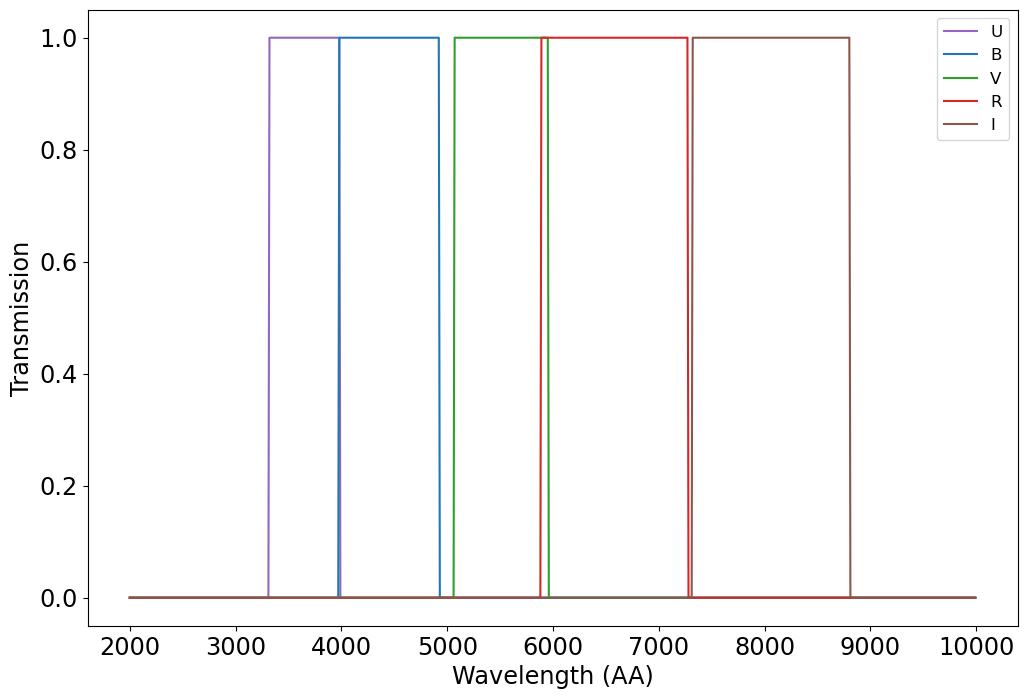

In [9]:
# mean WL (AA), full width at half maximum (AA), flux(lambda) for 0-magnitude (W/m²)
U_band_center, U_band_FWHM, U_band_f0 = 3650., 660., 3.981e-02
B_band_center, B_band_FWHM, B_band_f0 = 4450., 940., 6.310e-02
V_band_center, V_band_FWHM, V_band_f0 = 5510., 880., 3.631e-02
R_band_center, R_band_FWHM, R_band_f0 = 6580., 1380., 2.239e-02
I_band_center, I_band_FWHM, I_band_f0 = 8060., 1490., 1.148e-02

# FWHM = 2.sqrt(2.ln2).sigma for a normal distribution
U_band_sigma = U_band_FWHM/(2*np.sqrt(2*np.log(2)))
B_band_sigma = B_band_FWHM/(2*np.sqrt(2*np.log(2)))
V_band_sigma = V_band_FWHM/(2*np.sqrt(2*np.log(2)))
R_band_sigma = R_band_FWHM/(2*np.sqrt(2*np.log(2)))
I_band_sigma = I_band_FWHM/(2*np.sqrt(2*np.log(2)))

gauss_bands_dict = {\
                    "U":{"Mean": U_band_center,\
                         "Sigma": U_band_sigma,\
                         "f_0": U_band_f0\
                        },\
                    "B":{"Mean": B_band_center,\
                         "Sigma": B_band_sigma,\
                         "f_0": B_band_f0\
                        },\
                    "V":{"Mean": V_band_center,\
                         "Sigma": V_band_sigma,\
                         "f_0": V_band_f0\
                        },\
                    "R":{"Mean": R_band_center,\
                         "Sigma": R_band_sigma,\
                         "f_0": R_band_f0\
                        },\
                    "I":{"Mean": I_band_center,\
                         "Sigma": I_band_sigma,\
                         "f_0": I_band_f0\
                        }\
                   }

rect_bands_dict = {\
                   "U":{"Mean": U_band_center,\
                        "Width": U_band_FWHM,\
                        "f_0": U_band_f0\
                       },\
                   "B":{"Mean": B_band_center,\
                        "Width": B_band_FWHM,\
                        "f_0": B_band_f0\
                       },\
                   "V":{"Mean": V_band_center,\
                        "Width": V_band_FWHM,\
                        "f_0": V_band_f0\
                       },\
                   "R":{"Mean": R_band_center,\
                        "Width": R_band_FWHM,\
                        "f_0": R_band_f0\
                       },\
                   "I":{"Mean": I_band_center,\
                        "Width": I_band_FWHM,\
                        "f_0": I_band_f0\
                       }\
                  }

def gaussian_band(mu, sig, interp_step=1.):
    # Returns A FUNCTION that is created by 1D-interpolation of a normal distrib of mean mu and std dev sig
    # Interpolation range is defined arbitrarily as +/- 10sig
    # interpolation step is 1. (design case is we are working with angstrom units with a resolution of .1nm)
    _x = np.arange(mu-10*sig, mu+10*sig+interp_step, interp_step)
    _y = np.exp(-np.power(_x-mu, 2)/(2*np.power(sig, 2))) / (sig*np.power(2*np.pi, 0.5))
    _max = np.amax(_y)
    _y = _y/_max
    #_int = np.trapz(_y, _x)
    func = interp1d(_x, _y, bounds_error=False, fill_value=0.)
    return func

def rect_band(mu, width, interp_step=1.):
    # Returns A FUNCTION that is created by 1D-interpolation of a normal distrib of mean mu and std dev sig
    # Interpolation range is defined arbitrarily as +/- 10sig
    # interpolation step is 1. (design case is we are working with angstrom units with a resolution of .1nm)
    _x = np.arange(mu-width/2, mu+width/2+interp_step, interp_step)
    #_int = np.trapz(_y, _x)
    func = interp1d(_x, np.ones_like(_x), bounds_error=False, fill_value=0.)
    return func

def flux_in_band(wavelengths, spectrum, band_name, band_shape="window"):
    from astropy import constants as const
    if band_shape == "gaussian":
        _band = gaussian_band(band_name["Mean"], band_name["Sigma"])
    else:
        band_shape = "window"
        _band = rect_band(band_name["Mean"], band_name["Width"])
    _transm = spectrum * _band(wavelengths) # * ( const.c.value / np.power(wavelengths, 2) ) if flux-density is in f_nu(lambda) 
    flux = np.trapz(_transm, wavelengths)/(4*np.pi*(10.)**2) #(4*np.pi*(3.0857e17)**2) # DL=10pcs for absolute magnitudes
    return flux

def mag_in_band(wavelengths, spectrum, band_name):
    _flux = flux_in_band(wavelengths, spectrum, band_name)
    _mag0 = -2.5*np.log10(band_name["f_0"])
    mag = -2.5*np.log10(_flux) - _mag0
    return mag

def color_index(wavelengths, spectrum, band_1, band_2):
    _mag1 = mag_in_band(wavelengths, spectrum, band_1)
    _mag2 = mag_in_band(wavelengths, spectrum, band_2)
    color = _mag1 - _mag2
    return color

_wl = np.arange(2000., 10000., 10)

for _mu, _sig, _f0, c, l in zip([U_band_center, B_band_center, V_band_center, R_band_center, I_band_center],\
                                [U_band_sigma, B_band_sigma, V_band_sigma, R_band_sigma, I_band_sigma],\
                                [U_band_f0, B_band_f0, V_band_f0, R_band_f0, I_band_f0],\
                                ['tab:purple', 'tab:blue', 'tab:green', 'tab:red', 'tab:brown'],\
                                ['U', 'B', 'V', 'R', 'I']\
                               ):
    _band = rect_band(_mu, 2.355*_sig)
    _int = np.trapz(_band(_wl), _wl)
    plt.plot(_wl, _band(_wl), color=c, label=l)
    plt.xlabel("Wavelength (AA)")
    plt.ylabel("Transmission")
    plt.legend()
    print(_int)

## 2. Load FORS2 SEDs from Starlight

In [10]:
df_fors2SL_spec = pd.DataFrame()
df_fors2SL_spec_normed = pd.DataFrame()
df_fors2SL_spec['Wavelength'] = lambdas
df_fors2SL_spec_normed['Wavelength'] = lambdas
to_be_removed = {84, 89, 518, 210, 212, 267, 297, 346, 591, 722}
all_numbers = [ num for num in all_numbers if num not in to_be_removed ]
for _num in all_numbers:
    _path = os.path.join(path_BC, f'SPEC{_num}_HZ4_BC.txt')
    _arr = np.loadtxt(_path)
    _fonc = interp1d(_arr[:-1, 0], _arr[:-1, 1], bounds_error=False, fill_value=0.)
    lumins = _fonc(lambdas)
    _norm = np.trapz(lumins[mask], lambdas[mask])
    normed_spec = lumins/_norm
    
    _df_fors2SL_spec = df_fors2SL_spec.copy()
    _df_fors2SL_spec_normed = df_fors2SL_spec_normed.copy()
    _df_fors2SL_spec[ f'SPEC{_num}_HZ4_BC' ] = lumins
    _df_fors2SL_spec_normed[ f"SPEC{_num}_HZ4_BC_norm" ] = normed_spec
    df_fors2SL_spec = _df_fors2SL_spec.copy()
    df_fors2SL_spec_normed = _df_fors2SL_spec_normed.copy()
df_fors2SL_spec_normed

,Wavelength,SPEC2_HZ4_BC_norm,SPEC3_HZ4_BC_norm,SPEC9_HZ4_BC_norm,SPEC13_HZ4_BC_norm,SPEC19_HZ4_BC_norm,SPEC24_HZ4_BC_norm,SPEC25_HZ4_BC_norm,SPEC30_HZ4_BC_norm,SPEC31_HZ4_BC_norm,...,SPEC729_HZ4_BC_norm,SPEC730_HZ4_BC_norm,SPEC731_HZ4_BC_norm,SPEC732_HZ4_BC_norm,SPEC733_HZ4_BC_norm,SPEC734_HZ4_BC_norm,SPEC735_HZ4_BC_norm,SPEC736_HZ4_BC_norm,SPEC737_HZ4_BC_norm,SPEC738_HZ4_BC_norm
0,100.0,2.123262e-08,4.127603e-06,2.904613e-07,2.412674e-06,2.504524e-07,6.099303e-06,3.452383e-06,1.660303e-06,2.804976e-07,...,5.188929e-07,7.474156e-06,1.132981e-05,1.958655e-06,1.245724e-05,6.630559e-06,6.307479e-07,2.080573e-05,6.469632e-06,2.365647e-07
1,110.0,4.953054e-08,4.887909e-06,3.936981e-07,3.329297e-06,2.838240e-07,6.934950e-06,3.993403e-06,2.023386e-06,3.209948e-07,...,5.798335e-07,9.077424e-06,1.386136e-05,2.446690e-06,1.496068e-05,7.215901e-06,7.283984e-07,2.528322e-05,7.862482e-06,2.795689e-07
2,120.0,2.070358e-07,6.133562e-06,7.109366e-07,7.003680e-06,4.036198e-07,8.182642e-06,5.314695e-06,2.629848e-06,4.405604e-07,...,7.741666e-07,1.154183e-05,1.822193e-05,3.580833e-06,1.717493e-05,7.800009e-06,8.964236e-07,3.211766e-05,1.005207e-05,4.612337e-07
3,130.0,3.708856e-07,7.121950e-06,9.998715e-07,9.992923e-06,5.247040e-07,9.168920e-06,6.378500e-06,3.133685e-06,5.597345e-07,...,9.420793e-07,1.353129e-05,2.175225e-05,4.522914e-06,1.909187e-05,8.247746e-06,1.048744e-06,3.763106e-05,1.180853e-05,6.466242e-07
4,140.0,5.963363e-07,8.022365e-06,1.313492e-06,1.359808e-05,6.820372e-07,1.004877e-05,7.501543e-06,3.628603e-06,7.083409e-07,...,1.111576e-06,1.538374e-05,2.520292e-05,5.566573e-06,2.040852e-05,8.511284e-06,1.206557e-06,4.276500e-05,1.343149e-05,8.931383e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11865,99750.0,1.464750e-07,4.841996e-08,1.245283e-07,1.307585e-08,1.261592e-07,7.071369e-08,4.301176e-08,6.338417e-08,1.117000e-07,...,6.822294e-08,1.344602e-08,5.215542e-08,1.267117e-08,3.037251e-08,3.539816e-08,1.674850e-07,1.430855e-08,5.066279e-08,1.837873e-07
11866,99800.0,1.461817e-07,4.827621e-08,1.242674e-07,1.304885e-08,1.258754e-07,7.053741e-08,4.290678e-08,6.324667e-08,1.114208e-07,...,6.808089e-08,1.341684e-08,5.204353e-08,1.263450e-08,3.027837e-08,3.530946e-08,1.670159e-07,1.427425e-08,5.050146e-08,1.833598e-07
11867,99850.0,1.458953e-07,4.815369e-08,1.240192e-07,1.302306e-08,1.256091e-07,7.037882e-08,4.281232e-08,6.311704e-08,1.111707e-07,...,6.794541e-08,1.338940e-08,5.193780e-08,1.260299e-08,3.020049e-08,3.523005e-08,1.666129e-07,1.424297e-08,5.036679e-08,1.829670e-07
11868,99900.0,1.456088e-07,4.803116e-08,1.237711e-07,1.299727e-08,1.253429e-07,7.022023e-08,4.271787e-08,6.298741e-08,1.109205e-07,...,6.780993e-08,1.336195e-08,5.183208e-08,1.257148e-08,3.012262e-08,3.515063e-08,1.662099e-07,1.421170e-08,5.023212e-08,1.825743e-07


In [11]:
df_fors2SL_prop = pd.DataFrame(index=all_numbers)
df_fors2SL_prop["File"] = [os.path.join(path_BC, f'SPEC{_num}_HZ4_BC.txt') for _num in all_numbers]
df_fors2SL_prop["Spectrum"] = [f'SPEC{_num}_HZ4_BC' for _num in all_numbers]
df_fors2SL_prop["Normalized spectrum"] = [f'SPEC{_num}_HZ4_BC_norm' for _num in all_numbers]
df_fors2SL_prop["Redshift"] = [ t[t['ID']==_num]['z'][0] for _num in all_numbers ]

In [12]:
mag_list = ['U', 'B', 'V', 'R', 'I']
for band in mag_list:
    df_fors2SL_prop[f"M_{band}"] = [ mag_in_band(df_fors2SL_spec["Wavelength"], df_fors2SL_spec[_spec],\
                                                 rect_bands_dict[band])\
                                    for _spec in df_fors2SL_prop["Spectrum"] ]
    
for _c1, _c2 in zip(mag_list[:-1], mag_list[1:]):
    df_fors2SL_prop[f"{_c1}-{_c2}"] = df_fors2SL_prop[f"M_{_c1}"]-df_fors2SL_prop[f"M_{_c2}"]

In [13]:
df_fors2SL_prop

,File,Spectrum,Normalized spectrum,Redshift,M_U,M_B,M_V,M_R,M_I,U-B,B-V,V-R,R-I
2,/home/joseph/PhotoZ_PhD//ResStarlight/BC03N/co...,SPEC2_HZ4_BC,SPEC2_HZ4_BC_norm,0.34555,1.811829,1.219171,0.545979,-0.475799,-1.300298,0.592659,0.673191,1.021778,0.824499
3,/home/joseph/PhotoZ_PhD//ResStarlight/BC03N/co...,SPEC3_HZ4_BC,SPEC3_HZ4_BC_norm,0.68660,1.504275,1.125855,0.793535,-0.004439,-0.549635,0.378421,0.332320,0.797974,0.545195
9,/home/joseph/PhotoZ_PhD//ResStarlight/BC03N/co...,SPEC9_HZ4_BC,SPEC9_HZ4_BC_norm,0.29266,1.773509,1.080183,0.371102,-0.634547,-1.397843,0.693327,0.709081,1.005650,0.763296
13,/home/joseph/PhotoZ_PhD//ResStarlight/BC03N/co...,SPEC13_HZ4_BC,SPEC13_HZ4_BC_norm,0.68870,1.689047,2.159424,2.253565,1.667608,1.098274,-0.470377,-0.094142,0.585958,0.569334
19,/home/joseph/PhotoZ_PhD//ResStarlight/BC03N/co...,SPEC19_HZ4_BC,SPEC19_HZ4_BC_norm,0.48395,1.587842,1.123218,0.662675,-0.253780,-1.000210,0.464624,0.460543,0.916455,0.746430
...,...,...,...,...,...,...,...,...,...,...,...,...,...
734,/home/joseph/PhotoZ_PhD//ResStarlight/BC03N/co...,SPEC734_HZ4_BC,SPEC734_HZ4_BC_norm,0.23012,-0.979218,-1.091260,-1.456575,-2.306827,-2.949670,0.112042,0.365315,0.850252,0.642843
735,/home/joseph/PhotoZ_PhD//ResStarlight/BC03N/co...,SPEC735_HZ4_BC,SPEC735_HZ4_BC_norm,0.36169,-1.116730,-1.848421,-2.502770,-3.443533,-4.113837,0.731691,0.654349,0.940763,0.670304
736,/home/joseph/PhotoZ_PhD//ResStarlight/BC03N/co...,SPEC736_HZ4_BC,SPEC736_HZ4_BC_norm,0.55777,1.318080,1.436775,1.320905,0.609309,0.106624,-0.118695,0.115871,0.711596,0.502685
737,/home/joseph/PhotoZ_PhD//ResStarlight/BC03N/co...,SPEC737_HZ4_BC,SPEC737_HZ4_BC_norm,0.52001,0.555391,0.169535,-0.254942,-1.097180,-1.657871,0.385856,0.424476,0.842238,0.560691


In [14]:
if os.getenv('LEPHAREDIR') is not None:
    LEPHAREDIR = os.getenv('LEPHAREDIR')
else:
    LEPHAREDIR = os.path.abspath(os.path.join(os.getcwd(), "LEPHARE"))
print(LEPHAREDIR)
ref_seds = 'CWW_KINNEY'
sed_dir = os.path.join(LEPHAREDIR, 'sed/GAL', ref_seds)
print(sed_dir)

lephare_res_dir = 'lephare_cosmos'
if os.getenv('LEPHAREWORK') is not None:
    LEPHAREWORK = os.environ['LEPHAREWORK']
else:
    LEPHAREWORK = os.path.abspath(os.path.join(os.getcwd(),lephare_res_dir))
    os.environ['LEPHAREWORK'] = LEPHAREWORK
    
fmt='.sed'
seds = []
for f in os.listdir(sed_dir):
    if fmt in f:
        seds.append(f)
        
df_cww_spec = pd.DataFrame()
df_cww_spec_normed = pd.DataFrame()
df_cww_spec['Wavelength'] = lambdas
df_cww_spec_normed['Wavelength'] = lambdas
for sed in seds:
    spec_path = os.path.join(sed_dir, sed)
    spec_arr = np.loadtxt(spec_path)
    spec_fonc = interp1d(spec_arr[:-1, 0], spec_arr[:-1, 1], bounds_error=False, fill_value=0.)
    lumins = spec_fonc(lambdas)
    _norm = np.trapz(lumins[mask], lambdas[mask])
    normed_spec = lumins/_norm
    df_cww_spec[ sed.split('.')[0] ] = lumins
    df_cww_spec_normed[ f"{sed.split('.')[0]}_norm" ] = normed_spec

df_cww_spec_normed = df_cww_spec_normed.drop(columns=[f'KIN_SB{1+n}_ext_norm' for n in range(0,6)])

for _cww in df_cww_spec_normed.keys()[1:]:
    col_UB_cww = color_index(lambdas[mask], df_cww_spec_normed[_cww][mask], rect_bands_dict['U'], rect_bands_dict['B'])
    col_BV_cww = color_index(lambdas[mask], df_cww_spec_normed[_cww][mask], rect_bands_dict['B'], rect_bands_dict['V'])
    col_VR_cww = color_index(lambdas[mask], df_cww_spec_normed[_cww][mask], rect_bands_dict['V'], rect_bands_dict['R'])
    col_RI_cww = color_index(lambdas[mask], df_cww_spec_normed[_cww][mask], rect_bands_dict['R'], rect_bands_dict['I'])
    kin_name = "_".join(_cww.split('_')[:2])
    
    df_fors2SL_prop[f"Color-distance to {kin_name}"] = dist_color(df_fors2SL_prop['U-B'],\
                                                                  df_fors2SL_prop['B-V'],\
                                                                  df_fors2SL_prop['V-R'],\
                                                                  df_fors2SL_prop['R-I'],\
                                                                  col_UB_cww,\
                                                                  col_BV_cww,\
                                                                  col_VR_cww,\
                                                                  col_RI_cww\
                                                                 )
df_fors2SL_prop

/home/joseph/PhotoZ_PhD/LEPHARE
/home/joseph/PhotoZ_PhD/LEPHARE/sed/GAL/CWW_KINNEY


,File,Spectrum,Normalized spectrum,Redshift,M_U,M_B,M_V,M_R,M_I,U-B,B-V,V-R,R-I,Color-distance to CWW_Sbc,Color-distance to CWW_E,Color-distance to CWW_Im,Color-distance to CWW_Scd,Color-distance to KIN_Sb,Color-distance to KIN_Sa
2,/home/joseph/PhotoZ_PhD//ResStarlight/BC03N/co...,SPEC2_HZ4_BC,SPEC2_HZ4_BC_norm,0.34555,1.811829,1.219171,0.545979,-0.475799,-1.300298,0.592659,0.673191,1.021778,0.824499,0.337586,0.378350,0.863927,0.563574,0.102251,0.175160
3,/home/joseph/PhotoZ_PhD//ResStarlight/BC03N/co...,SPEC3_HZ4_BC,SPEC3_HZ4_BC_norm,0.68660,1.504275,1.125855,0.793535,-0.004439,-0.549635,0.378421,0.332320,0.797974,0.545195,0.279656,0.786726,0.473019,0.193821,0.607487,0.643401
9,/home/joseph/PhotoZ_PhD//ResStarlight/BC03N/co...,SPEC9_HZ4_BC,SPEC9_HZ4_BC_norm,0.29266,1.773509,1.080183,0.371102,-0.634547,-1.397843,0.693327,0.709081,1.005650,0.763296,0.422760,0.263468,0.946313,0.627546,0.071124,0.091459
13,/home/joseph/PhotoZ_PhD//ResStarlight/BC03N/co...,SPEC13_HZ4_BC,SPEC13_HZ4_BC_norm,0.68870,1.689047,2.159424,2.253565,1.667608,1.098274,-0.470377,-0.094142,0.585958,0.569334,1.069072,1.733379,0.553897,0.878506,1.496283,1.554764
19,/home/joseph/PhotoZ_PhD//ResStarlight/BC03N/co...,SPEC19_HZ4_BC,SPEC19_HZ4_BC_norm,0.48395,1.587842,1.123218,0.662675,-0.253780,-1.000210,0.464624,0.460543,0.916455,0.746430,0.128218,0.592847,0.618262,0.324956,0.366388,0.414841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
734,/home/joseph/PhotoZ_PhD//ResStarlight/BC03N/co...,SPEC734_HZ4_BC,SPEC734_HZ4_BC_norm,0.23012,-0.979218,-1.091260,-1.456575,-2.306827,-2.949670,0.112042,0.365315,0.850252,0.642843,0.286731,0.952980,0.245147,0.123519,0.709651,0.769048
735,/home/joseph/PhotoZ_PhD//ResStarlight/BC03N/co...,SPEC735_HZ4_BC,SPEC735_HZ4_BC_norm,0.36169,-1.116730,-1.848421,-2.502770,-3.443533,-4.113837,0.731691,0.654349,0.940763,0.670304,0.427915,0.275452,0.929395,0.598894,0.198728,0.186587
736,/home/joseph/PhotoZ_PhD//ResStarlight/BC03N/co...,SPEC736_HZ4_BC,SPEC736_HZ4_BC_norm,0.55777,1.318080,1.436775,1.320905,0.609309,0.106624,-0.118695,0.115871,0.711596,0.502685,0.671790,1.316987,0.182416,0.458524,1.092895,1.146047
737,/home/joseph/PhotoZ_PhD//ResStarlight/BC03N/co...,SPEC737_HZ4_BC,SPEC737_HZ4_BC_norm,0.52001,0.555391,0.169535,-0.254942,-1.097180,-1.657871,0.385856,0.424476,0.842238,0.560691,0.207707,0.712967,0.508908,0.181571,0.521284,0.561640


In [15]:
colorNeighbour=True

if colorNeighbour:
    for _num in all_numbers:
        _sed = f"SPEC{_num}_HZ4_BC_norm"
        _cww = df_cww_spec_normed.keys()[1]
        kin_name = "_".join(_cww.split('_')[:2])
        nearest = kin_name
        dist = df_fors2SL_prop.loc[_num, f"Color-distance to {kin_name}"]
        #print(dist)

        for _cww in df_cww_spec_normed.keys()[2:]:
            kin_name = "_".join(_cww.split('_')[:2])
            _dist = df_fors2SL_prop.loc[_num, f"Color-distance to {kin_name}"]
            if _dist < dist:
                nearest = kin_name
                dist = _dist
        df_fors2SL_prop.loc[_num, "Nearest ref"] = nearest
else:
    for _num in all_numbers:
        _sed = f"SPEC{_num}_HZ4_BC_norm"
        nearest = df_cww_spec_normed.keys()[1]
        _wl = df_fors2SL_spec_normed['Wavelength']
        dist = abs(dist_spec(df_fors2SL_spec_normed[_sed], df_cww_spec_normed[nearest],\
                             _wl, KL_div=False))
        for _cww in df_cww_spec_normed.keys()[2:]:
            _dist = abs(dist_spec(df_fors2SL_spec_normed[_sed], df_cww_spec_normed[_cww],\
                                  _wl, KL_div=False))
            if _dist < dist:
                nearest = _cww
                dist = _dist
        df_fors2SL_prop.loc[_num, "Nearest ref"] = nearest

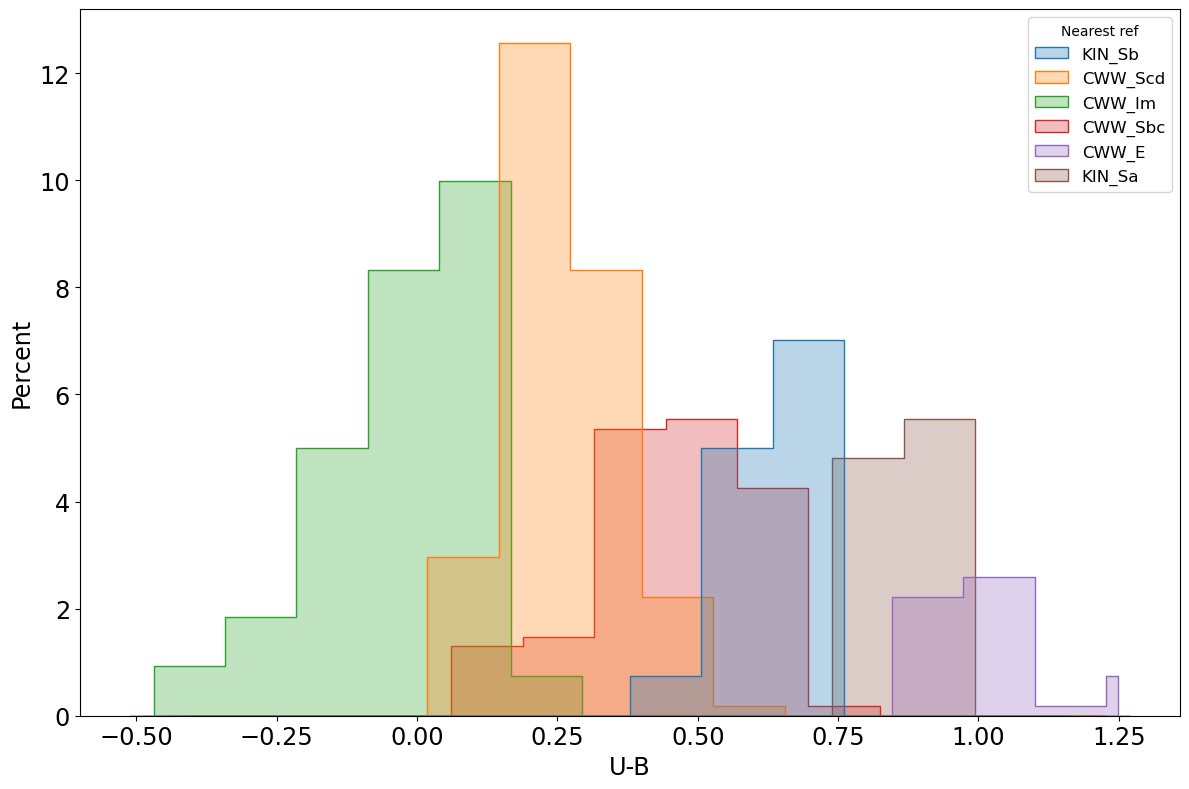

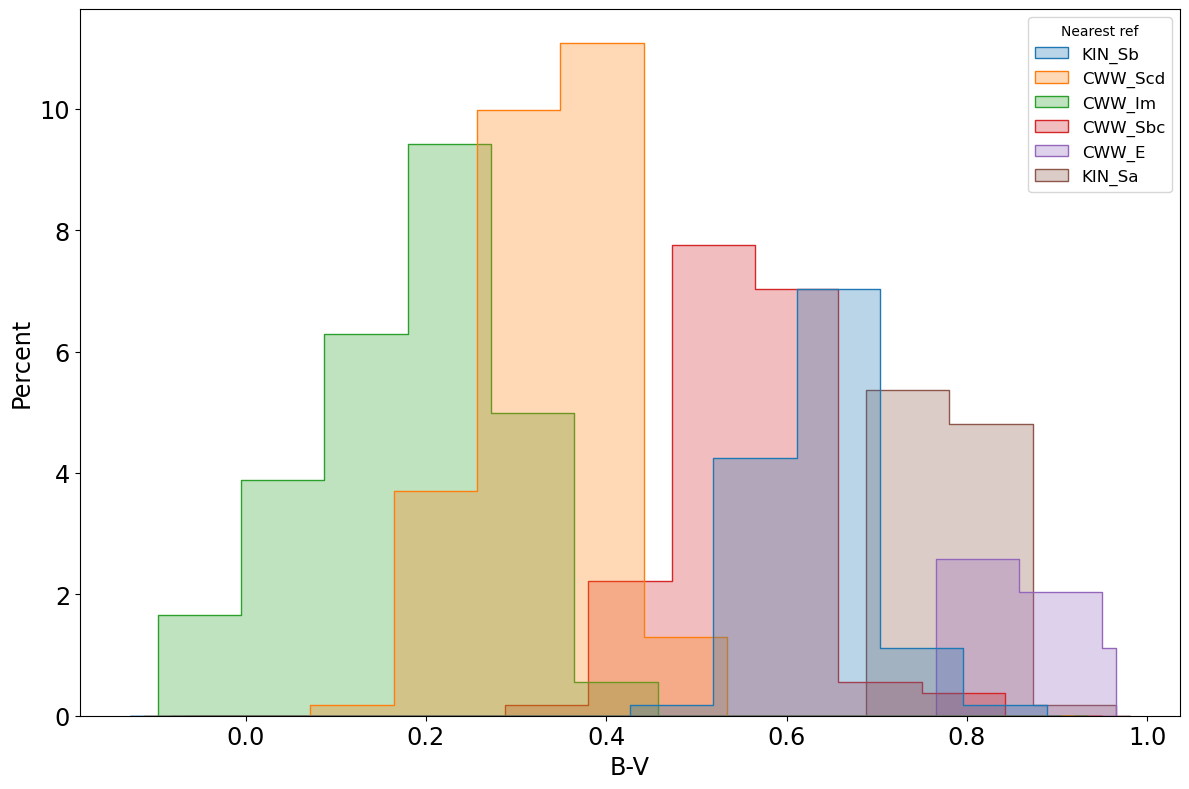

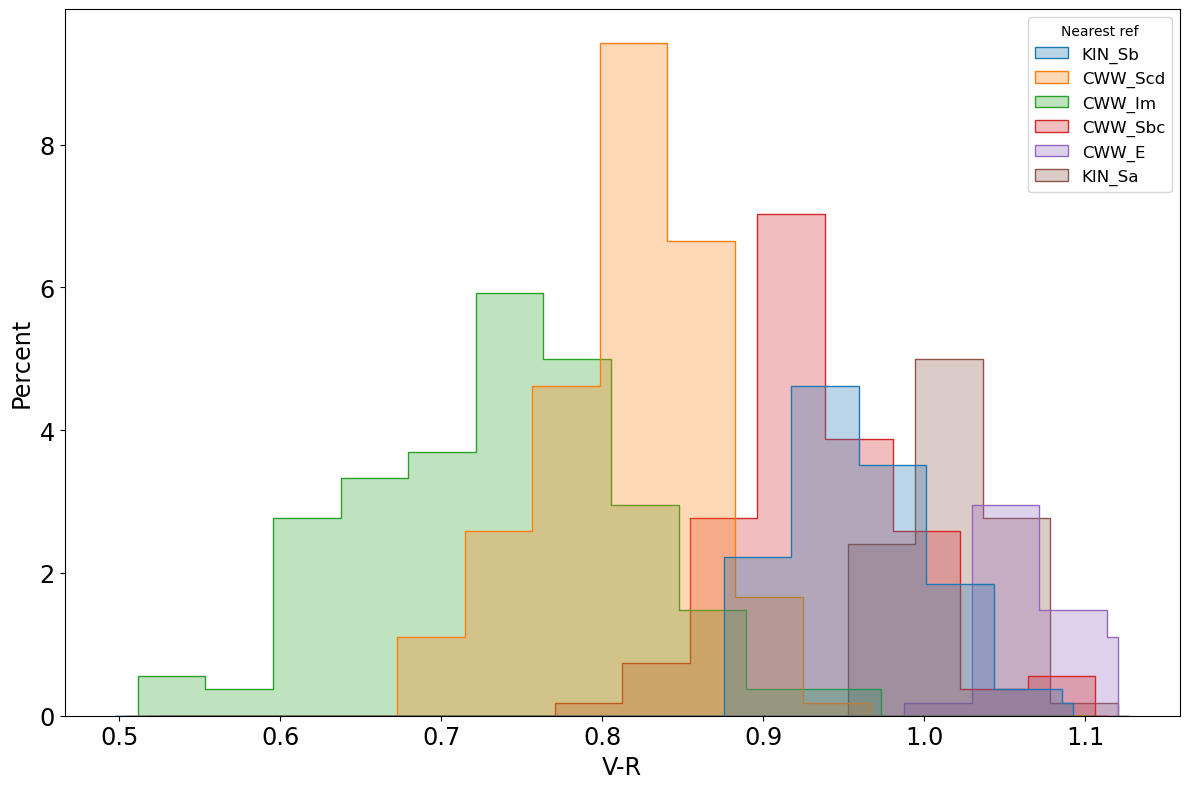

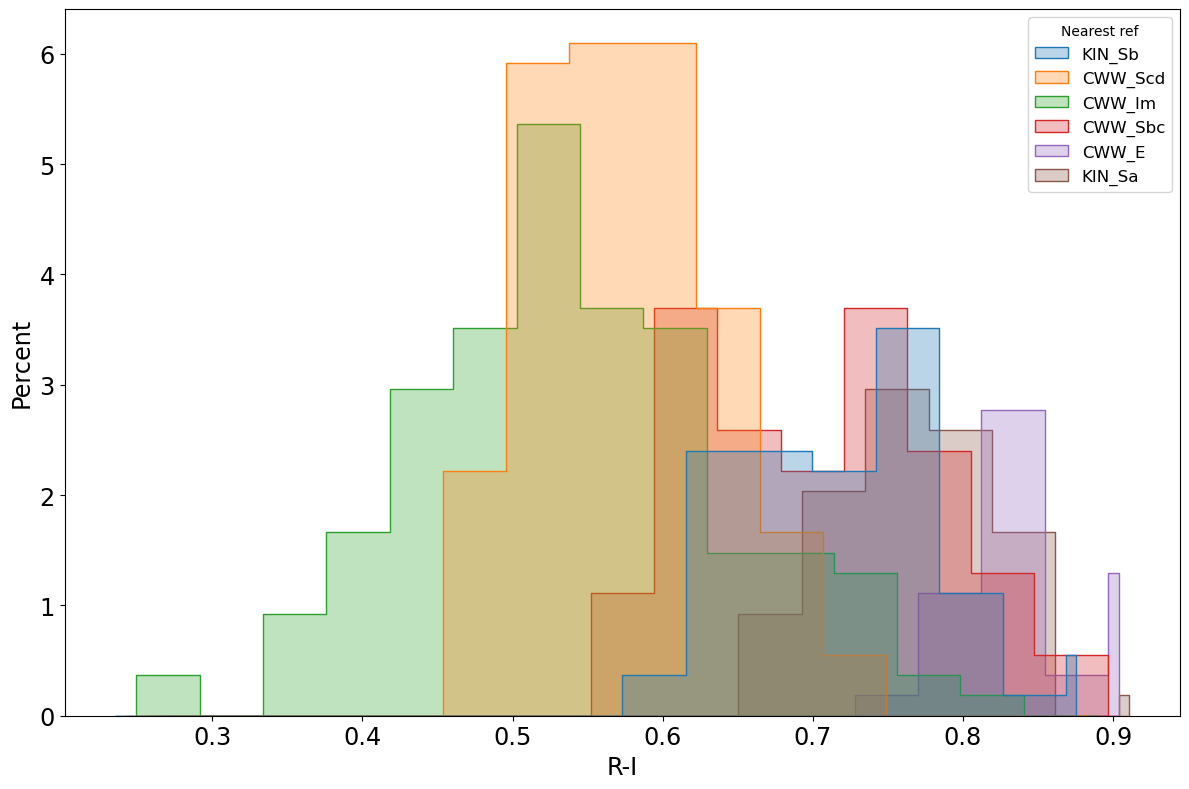

In [16]:
for colInd in ['U-B', 'B-V', 'V-R', 'R-I']:
    f,a = plt.subplots(1,1)
    sns.histplot(data=df_fors2SL_prop, x=colInd, bins='auto', hue="Nearest ref",\
                 stat='percent', element='step', multiple='dodge',\
                 ax=a, alpha=0.3)#, log_scale=(False,True))
    f.set_tight_layout(True)

# 3. Select FORS2-Starlight galaxies in each color index bin

In [17]:
_listOfNums = np.empty_like([], dtype=int)
bin_edges = {}
sel_2d = True
exclude_Im = False
use_average = True

df_4D_col_avg = pd.DataFrame()
df_4D_col_avg['Wavelength'] = df_fors2SL_spec['Wavelength']
df_4D_col_avg_normed = pd.DataFrame()
df_4D_col_avg_normed['Wavelength'] = df_fors2SL_spec_normed['Wavelength']
df_4D_col_avg_prop = pd.DataFrame()

for _c1, _c2 in zip(mag_list[:-1], mag_list[1:]):
    colInd = f"{_c1}-{_c2}"
    _counts, _binEdges = np.histogram(df_fors2SL_prop[colInd], bins=5)
    bin_edges['binEdges_'+colInd] = _binEdges
    
if True:
    loc=0
    for _infUB, _supUB in zip(bin_edges['binEdges_U-B'][:-1], bin_edges['binEdges_U-B'][1:]):
        _selUB = (df_fors2SL_prop['U-B']>=_infUB) * (df_fors2SL_prop['U-B']<=_supUB)
        for _infBV, _supBV in zip(bin_edges['binEdges_B-V'][:-1], bin_edges['binEdges_B-V'][1:]):
            _selBV = (df_fors2SL_prop['B-V']>=_infBV) * (df_fors2SL_prop['B-V']<=_supBV)
            for _infVR, _supVR in zip(bin_edges['binEdges_V-R'][:-1], bin_edges['binEdges_V-R'][1:]):
                _selVR = (df_fors2SL_prop['V-R']>=_infVR) * (df_fors2SL_prop['V-R']<=_supVR)
                for _infRI, _supRI in zip(bin_edges['binEdges_R-I'][:-1], bin_edges['binEdges_R-I'][1:]):
                    _selRI = (df_fors2SL_prop['R-I']>=_infRI) * (df_fors2SL_prop['R-I']<=_supRI)
                    _sel = _selUB * _selBV * _selVR * _selRI
                    if exclude_Im:
                        _sel = _sel * (df_fors2SL_prop['Nearest ref'] != "CWW_Im")
                    _selList = sorted(df_fors2SL_prop.index[_sel])
                    if len(_selList) > 0:
                        loc+=1
                        _wl = np.asarray(df_fors2SL_spec_normed['Wavelength'])
                        #print(len(_wl))
                        _table = np.zeros_like(_wl)
                        _table_norm = np.zeros_like(_wl)
                        _zs = []

                        _str = '_'.join(('AVG',\
                                         f'UB{0.5*(_infUB+_supUB):.2f}',\
                                         f'BV{0.5*(_infBV+_supBV):.2f}',\
                                         f'VR{0.5*(_infVR+_supVR):.2f}',\
                                         f'RI{0.5*(_infRI+_supRI):.2f}'\
                                        ))
                        for n in _selList:
                            _table_norm = np.column_stack((_table_norm,\
                                                           df_fors2SL_spec_normed[f'SPEC{int(n)}_HZ4_BC_norm']\
                                                          ))
                            _table = np.column_stack((_table,\
                                                      df_fors2SL_spec[f'SPEC{int(n)}_HZ4_BC']\
                                                     ))
                            _zs = np.append(_zs, df_fors2SL_prop.loc[n, 'Redshift'])
                        #print(_table[:,0])
                        #print(_table)
                        _table = _table[:,1:]
                        _table_norm = _table_norm[:,1:]
                        avg_sed = np.mean(_table, axis=1, dtype=np.float64)
                        avg_sed_norm = np.mean(_table_norm, axis=1, dtype=np.float64)
                        df_4D_col_avg[_str] = avg_sed
                        df_4D_col_avg_normed[_str+'_norm'] = avg_sed_norm

                        df_4D_col_avg_prop.loc[f"AVG_{loc}", "Spectrum"] = _str
                        df_4D_col_avg_prop.loc[f"AVG_{loc}", "Normalized spectrum"] = _str+'_norm'
                        df_4D_col_avg_prop.loc[f"AVG_{loc}", 'Redshift'] = np.mean(_zs)
                        for band in mag_list:
                            df_4D_col_avg_prop.loc[f"AVG_{loc}", f"M_{band}"] = [ mag_in_band(_wl, avg_sed,\
                                                                                              rect_bands_dict[band]) ]

                        for _c1, _c2 in zip(mag_list[:-1], mag_list[1:]):
                            df_4D_col_avg_prop.loc[f"AVG_{loc}", f"{_c1}-{_c2}"] = df_4D_col_avg_prop.loc[f"AVG_{loc}", f"M_{_c1}"]\
                                                                                   - df_4D_col_avg_prop.loc[f"AVG_{loc}", f"M_{_c2}"]

                        for _cww in df_cww_spec_normed.keys()[1:]:
                            col_UB_cww = color_index(lambdas[mask], df_cww_spec_normed[_cww][mask], rect_bands_dict['U'], rect_bands_dict['B'])
                            col_BV_cww = color_index(lambdas[mask], df_cww_spec_normed[_cww][mask], rect_bands_dict['B'], rect_bands_dict['V'])
                            col_VR_cww = color_index(lambdas[mask], df_cww_spec_normed[_cww][mask], rect_bands_dict['V'], rect_bands_dict['R'])
                            col_RI_cww = color_index(lambdas[mask], df_cww_spec_normed[_cww][mask], rect_bands_dict['R'], rect_bands_dict['I'])
                            kin_name = "_".join(_cww.split('_')[:2])

                            df_4D_col_avg_prop.loc[f"AVG_{loc}", f"Color-distance to {kin_name}"] = dist_color(df_4D_col_avg_prop.loc[f"AVG_{loc}", 'U-B'],\
                                                                                                            df_4D_col_avg_prop.loc[f"AVG_{loc}", 'B-V'],\
                                                                                                            df_4D_col_avg_prop.loc[f"AVG_{loc}", 'V-R'],\
                                                                                                            df_4D_col_avg_prop.loc[f"AVG_{loc}", 'R-I'],\
                                                                                                            col_UB_cww,\
                                                                                                            col_BV_cww,\
                                                                                                            col_VR_cww,\
                                                                                                            col_RI_cww\
                                                                                                           )
                        if colorNeighbour:
                            _cww = df_cww_spec_normed.keys()[1]
                            kin_name = "_".join(_cww.split('_')[:2])
                            nearest = kin_name
                            dist = df_4D_col_avg_prop.loc[f"AVG_{loc}", f"Color-distance to {kin_name}"]
                            #print(dist)

                            for _cww in df_cww_spec_normed.keys()[2:]:
                                kin_name = "_".join(_cww.split('_')[:2])
                                _dist = df_4D_col_avg_prop.loc[f"AVG_{loc}", f"Color-distance to {kin_name}"]
                                if _dist < dist:
                                    nearest = kin_name
                                    dist = _dist
                            df_4D_col_avg_prop.loc[f"AVG_{loc}", "Nearest ref"] = nearest
                        else:
                            nearest = df_cww_spec_normed.keys()[1]
                            dist = abs(dist_spec(avg_sed_norm, df_cww_spec_normed[nearest],\
                                                 _wl, KL_div=False))
                            for _cww in df_cww_spec_normed.keys()[2:]:
                                _dist = abs(dist_spec(avg_sed_norm, df_cww_spec_normed[_cww],\
                                                      _wl, KL_div=False))
                                if _dist < dist:
                                    nearest = _cww
                                    dist = _dist
                            df_4D_col_avg_prop.loc[_num, "Nearest ref"] = nearest
                            
                        _listOfNums = np.append(_listOfNums, int(_selList[0]))
elif sel_2d:
    for _c1, _c2, _c3 in zip(mag_list[:-2], mag_list[1:-1], mag_list[2:]):
        colIndX, colIndY = f"{_c1}-{_c2}", f"{_c2}-{_c3}"
        _binEdgesX = bin_edges['binEdges_'+colIndX]
        _binEdgesY = bin_edges['binEdges_'+colIndY]
        for _infX, _supX in zip(_binEdgesX[:-1], _binEdgesX[1:]):
            for _infY, _supY in zip(_binEdgesY[:-1], _binEdgesY[1:]):
                _mask = (df_fors2SL_prop[colIndX] >= _infX) * (df_fors2SL_prop[colIndX] <= _supX) * (df_fors2SL_prop[colIndY] >= _infY) * (df_fors2SL_prop[colIndY] <= _supY)
                _selList = sorted(df_fors2SL_prop.index[_mask])
                if len(_selList) > 0:
                    _listOfNums = np.append(_listOfNums, int(_selList[0]))
else:
    for _c1, _c2 in zip(mag_list[:-1], mag_list[1:]):
        colIndX = f"{_c1}-{_c2}"
        _binEdgesX = bin_edges['binEdges_'+colIndX]
        for _infX, _supX in zip(_binEdgesX[:-1], _binEdgesX[1:]):
            _mask = (df_fors2SL_prop[colIndX] >= _infX) * (df_fors2SL_prop[colIndX] <= _supX)
            _selList = sorted(df_fors2SL_prop.index[_mask])
            if len(_selList) > 0:
                _listOfNums = np.append(_listOfNums, int(_selList[0]))
listOfNums = np.unique(_listOfNums)

In [18]:
len(listOfNums)

59

In [19]:
df_fors2SL_prop["Selected"] = [ (not use_average) and (_ind in listOfNums) for _ind in df_fors2SL_prop.index ]
df_4D_col_avg_prop["Selected"] = use_average

In [20]:
df_fors2SL_prop

,File,Spectrum,Normalized spectrum,Redshift,M_U,M_B,M_V,M_R,M_I,U-B,...,V-R,R-I,Color-distance to CWW_Sbc,Color-distance to CWW_E,Color-distance to CWW_Im,Color-distance to CWW_Scd,Color-distance to KIN_Sb,Color-distance to KIN_Sa,Nearest ref,Selected
2,/home/joseph/PhotoZ_PhD//ResStarlight/BC03N/co...,SPEC2_HZ4_BC,SPEC2_HZ4_BC_norm,0.34555,1.811829,1.219171,0.545979,-0.475799,-1.300298,0.592659,...,1.021778,0.824499,0.337586,0.378350,0.863927,0.563574,0.102251,0.175160,KIN_Sb,False
3,/home/joseph/PhotoZ_PhD//ResStarlight/BC03N/co...,SPEC3_HZ4_BC,SPEC3_HZ4_BC_norm,0.68660,1.504275,1.125855,0.793535,-0.004439,-0.549635,0.378421,...,0.797974,0.545195,0.279656,0.786726,0.473019,0.193821,0.607487,0.643401,CWW_Scd,False
9,/home/joseph/PhotoZ_PhD//ResStarlight/BC03N/co...,SPEC9_HZ4_BC,SPEC9_HZ4_BC_norm,0.29266,1.773509,1.080183,0.371102,-0.634547,-1.397843,0.693327,...,1.005650,0.763296,0.422760,0.263468,0.946313,0.627546,0.071124,0.091459,KIN_Sb,False
13,/home/joseph/PhotoZ_PhD//ResStarlight/BC03N/co...,SPEC13_HZ4_BC,SPEC13_HZ4_BC_norm,0.68870,1.689047,2.159424,2.253565,1.667608,1.098274,-0.470377,...,0.585958,0.569334,1.069072,1.733379,0.553897,0.878506,1.496283,1.554764,CWW_Im,False
19,/home/joseph/PhotoZ_PhD//ResStarlight/BC03N/co...,SPEC19_HZ4_BC,SPEC19_HZ4_BC_norm,0.48395,1.587842,1.123218,0.662675,-0.253780,-1.000210,0.464624,...,0.916455,0.746430,0.128218,0.592847,0.618262,0.324956,0.366388,0.414841,CWW_Sbc,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
734,/home/joseph/PhotoZ_PhD//ResStarlight/BC03N/co...,SPEC734_HZ4_BC,SPEC734_HZ4_BC_norm,0.23012,-0.979218,-1.091260,-1.456575,-2.306827,-2.949670,0.112042,...,0.850252,0.642843,0.286731,0.952980,0.245147,0.123519,0.709651,0.769048,CWW_Scd,False
735,/home/joseph/PhotoZ_PhD//ResStarlight/BC03N/co...,SPEC735_HZ4_BC,SPEC735_HZ4_BC_norm,0.36169,-1.116730,-1.848421,-2.502770,-3.443533,-4.113837,0.731691,...,0.940763,0.670304,0.427915,0.275452,0.929395,0.598894,0.198728,0.186587,KIN_Sa,False
736,/home/joseph/PhotoZ_PhD//ResStarlight/BC03N/co...,SPEC736_HZ4_BC,SPEC736_HZ4_BC_norm,0.55777,1.318080,1.436775,1.320905,0.609309,0.106624,-0.118695,...,0.711596,0.502685,0.671790,1.316987,0.182416,0.458524,1.092895,1.146047,CWW_Im,False
737,/home/joseph/PhotoZ_PhD//ResStarlight/BC03N/co...,SPEC737_HZ4_BC,SPEC737_HZ4_BC_norm,0.52001,0.555391,0.169535,-0.254942,-1.097180,-1.657871,0.385856,...,0.842238,0.560691,0.207707,0.712967,0.508908,0.181571,0.521284,0.561640,CWW_Scd,False


In [21]:
df_4D_col_avg_prop

,Spectrum,Normalized spectrum,Redshift,M_U,M_B,M_V,M_R,M_I,U-B,B-V,V-R,R-I,Color-distance to CWW_Sbc,Color-distance to CWW_E,Color-distance to CWW_Im,Color-distance to CWW_Scd,Color-distance to KIN_Sb,Color-distance to KIN_Sa,Nearest ref,Selected
AVG_1,AVG_UB-0.33_BV-0.02_VR0.56_RI0.30,AVG_UB-0.33_BV-0.02_VR0.56_RI0.30_norm,0.359117,-0.334099,-0.044071,-0.001591,-0.557284,-0.869979,-0.290028,-0.042480,0.555693,0.312695,0.998300,1.617002,0.515526,0.771654,1.411006,1.460059,CWW_Im,True
AVG_2,AVG_UB-0.33_BV-0.02_VR0.56_RI0.44,AVG_UB-0.33_BV-0.02_VR0.56_RI0.44_norm,0.376257,0.347164,0.546615,0.546184,-0.061782,-0.456749,-0.199451,0.000431,0.607967,0.394967,0.864997,1.490385,0.386266,0.643331,1.280408,1.329937,CWW_Im,True
AVG_3,AVG_UB-0.33_BV-0.02_VR0.56_RI0.57,AVG_UB-0.33_BV-0.02_VR0.56_RI0.57_norm,0.601375,1.921957,2.310940,2.369748,1.768452,1.209028,-0.388984,-0.058807,0.601296,0.559424,0.985148,1.646209,0.471629,0.791731,1.412150,1.469553,CWW_Im,True
AVG_4,AVG_UB-0.33_BV-0.02_VR0.56_RI0.71,AVG_UB-0.33_BV-0.02_VR0.56_RI0.71_norm,0.979000,2.570330,2.976297,3.102196,2.524965,1.812732,-0.405967,-0.125899,0.577231,0.712233,1.029541,1.694088,0.543934,0.863550,1.454073,1.513277,CWW_Im,True
AVG_5,AVG_UB-0.33_BV-0.02_VR0.69_RI0.44,AVG_UB-0.33_BV-0.02_VR0.69_RI0.44_norm,0.725375,0.938507,1.208751,1.151392,0.483495,0.045739,-0.270244,0.057359,0.667897,0.437756,0.846022,1.491307,0.335788,0.628871,1.266609,1.320709,CWW_Im,True
AVG_6,AVG_UB-0.33_BV-0.02_VR0.69_RI0.57,AVG_UB-0.33_BV-0.02_VR0.69_RI0.57_norm,0.607305,1.555493,1.873966,1.877002,1.208347,0.610419,-0.318473,-0.003037,0.668656,0.597927,0.873790,1.539176,0.359470,0.686658,1.300810,1.358795,CWW_Im,True
AVG_7,AVG_UB-0.33_BV0.20_VR0.69_RI0.44,AVG_UB-0.33_BV0.20_VR0.69_RI0.44_norm,0.419553,-1.089786,-0.881483,-1.009425,-1.730247,-2.221405,-0.208303,0.127942,0.720822,0.491159,0.731084,1.383516,0.217222,0.518701,1.152704,1.208473,CWW_Im,True
AVG_8,AVG_UB-0.33_BV0.20_VR0.69_RI0.57,AVG_UB-0.33_BV0.20_VR0.69_RI0.57_norm,0.315265,1.708390,1.898421,1.785242,1.057891,0.525582,-0.190031,0.113179,0.727351,0.532309,0.710503,1.367822,0.191880,0.505944,1.134644,1.190731,CWW_Im,True
AVG_9,AVG_UB-0.33_BV0.20_VR0.81_RI0.44,AVG_UB-0.33_BV0.20_VR0.81_RI0.44_norm,0.801880,1.088518,1.247399,1.045574,0.280932,-0.224265,-0.158881,0.201825,0.764642,0.505197,0.641768,1.295066,0.139235,0.429334,1.060949,1.117784,CWW_Im,True
AVG_10,AVG_UB-0.33_BV0.20_VR0.81_RI0.57,AVG_UB-0.33_BV0.20_VR0.81_RI0.57_norm,0.571595,2.417595,2.695323,2.529445,1.776756,1.226592,-0.277728,0.165878,0.752689,0.550163,0.743205,1.408789,0.223953,0.546872,1.165221,1.225468,CWW_Im,True


In [22]:
# Concaténation des dataframes :
_df1 = df_fors2SL_prop.drop(columns=['File'])
_indices = [ f'id{id}' for id in _df1.index ]
_df1.index = _indices
df_to_save = pd.concat([_df1, df_4D_col_avg_prop])
df_to_save

,Spectrum,Normalized spectrum,Redshift,M_U,M_B,M_V,M_R,M_I,U-B,B-V,V-R,R-I,Color-distance to CWW_Sbc,Color-distance to CWW_E,Color-distance to CWW_Im,Color-distance to CWW_Scd,Color-distance to KIN_Sb,Color-distance to KIN_Sa,Nearest ref,Selected
id2,SPEC2_HZ4_BC,SPEC2_HZ4_BC_norm,0.345550,1.811829,1.219171,0.545979,-0.475799,-1.300298,0.592659,0.673191,1.021778,0.824499,0.337586,0.378350,0.863927,0.563574,0.102251,0.175160,KIN_Sb,False
id3,SPEC3_HZ4_BC,SPEC3_HZ4_BC_norm,0.686600,1.504275,1.125855,0.793535,-0.004439,-0.549635,0.378421,0.332320,0.797974,0.545195,0.279656,0.786726,0.473019,0.193821,0.607487,0.643401,CWW_Scd,False
id9,SPEC9_HZ4_BC,SPEC9_HZ4_BC_norm,0.292660,1.773509,1.080183,0.371102,-0.634547,-1.397843,0.693327,0.709081,1.005650,0.763296,0.422760,0.263468,0.946313,0.627546,0.071124,0.091459,KIN_Sb,False
id13,SPEC13_HZ4_BC,SPEC13_HZ4_BC_norm,0.688700,1.689047,2.159424,2.253565,1.667608,1.098274,-0.470377,-0.094142,0.585958,0.569334,1.069072,1.733379,0.553897,0.878506,1.496283,1.554764,CWW_Im,False
id19,SPEC19_HZ4_BC,SPEC19_HZ4_BC_norm,0.483950,1.587842,1.123218,0.662675,-0.253780,-1.000210,0.464624,0.460543,0.916455,0.746430,0.128218,0.592847,0.618262,0.324956,0.366388,0.414841,CWW_Sbc,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AVG_55,AVG_UB0.74_BV0.65_VR1.06_RI0.71,AVG_UB0.74_BV0.65_VR1.06_RI0.71_norm,0.393050,0.728996,-0.051058,-0.781923,-1.790829,-2.556602,0.780054,0.730866,1.008905,0.765773,0.507875,0.178010,1.029791,0.708320,0.129354,0.084964,KIN_Sa,True
AVG_56,AVG_UB0.74_BV0.65_VR1.06_RI0.84,AVG_UB0.74_BV0.65_VR1.06_RI0.84_norm,0.564405,0.754768,-0.045707,-0.781777,-1.800811,-2.594073,0.800475,0.736070,1.019034,0.793262,0.532103,0.165875,1.055900,0.737448,0.141991,0.092191,KIN_Sa,True
AVG_57,AVG_UB0.74_BV0.87_VR1.06_RI0.71,AVG_UB0.74_BV0.87_VR1.06_RI0.71_norm,0.331125,0.308091,-0.565767,-1.348460,-2.360163,-3.112111,0.873858,0.782693,1.011703,0.751948,0.613406,0.079197,1.132534,0.806713,0.225627,0.164738,CWW_E,True
AVG_58,AVG_UB0.74_BV0.87_VR1.06_RI0.84,AVG_UB0.74_BV0.87_VR1.06_RI0.84_norm,0.451725,0.455059,-0.373818,-1.171519,-2.215808,-3.030501,0.828877,0.797701,1.044289,0.814693,0.593604,0.140645,1.119259,0.801710,0.180223,0.131203,KIN_Sa,True


In [23]:
if True:
    df_to_save.to_pickle('fors2SED_colorSelect_v5.pkl')

31
62


(0.0, 20000.0)

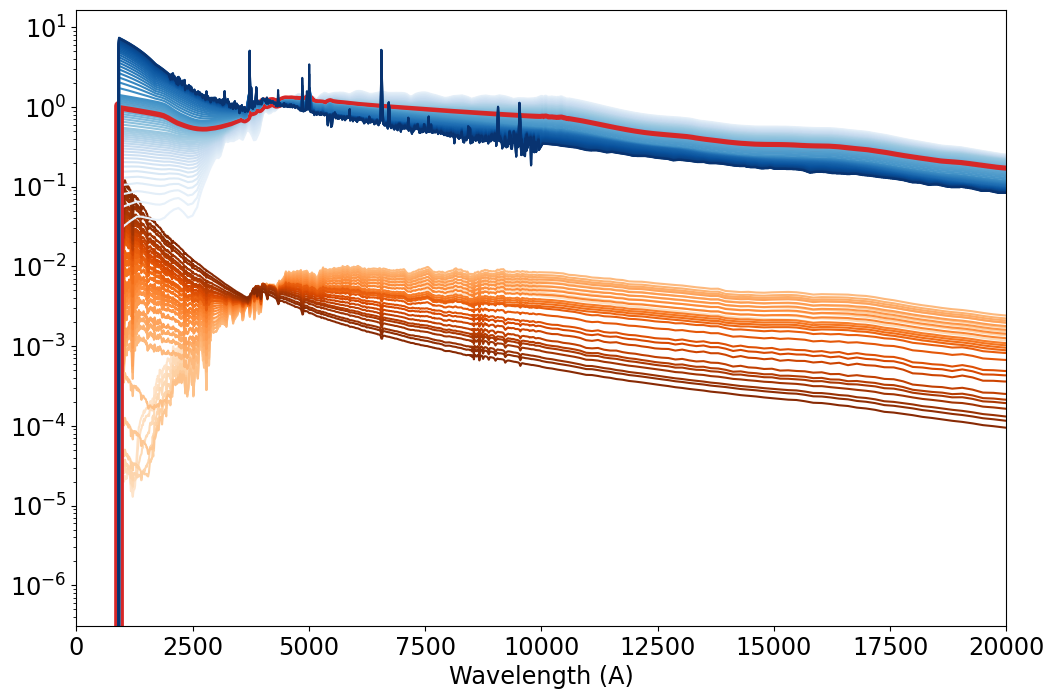

In [24]:
vista_list_file = "COSMOS_MOD.list" # CFHTLS_MOD.list
vista_dir = "COSMOS_SED" # CFHTLS_230506
with open(os.path.join(LEPHAREDIR, 'sed/GAL', vista_dir, vista_list_file),'r') as _f:
    _seds_list = _f.readlines()
paths_to_vistas = [os.path.join(LEPHAREDIR, 'sed/GAL', _sed.split(" ")[0]) for _sed in _seds_list]
print(len(paths_to_vistas))

oranges = plt.get_cmap('Oranges')
oraNorm = colors.Normalize(vmin=-5, vmax=len(paths_to_vistas))
oraMap = cmx.ScalarMappable(norm=oraNorm, cmap=oranges)

all_oranges = oraMap.to_rgba(np.arange(len(paths_to_vistas)), alpha=1)

for (_sed, col) in zip(paths_to_vistas, all_oranges):
    sed_arr = np.loadtxt(_sed)
    plt.plot(sed_arr[:, 0], sed_arr[:, 1], color=col)
    plt.xlim(0., 100000.)
    plt.yscale('log')
    

cfh_list_file = "CFHTLS_MOD.list"
cfh_dir = "CFHTLS_230506"
with open(os.path.join(LEPHAREDIR, 'sed/GAL', cfh_dir, cfh_list_file),'r') as _f:
    _seds_list = _f.readlines()
paths_to_cfhs = [os.path.join(LEPHAREDIR, 'sed/GAL', _sed.split(" ")[0]) for _sed in _seds_list]
print(len(paths_to_cfhs))

blues = plt.get_cmap('Blues')
bluNorm = colors.Normalize(vmin=-5, vmax=len(paths_to_cfhs))
bluMap = cmx.ScalarMappable(norm=bluNorm, cmap=blues)

all_blues = bluMap.to_rgba(np.arange(len(paths_to_cfhs)), alpha=1)

for (_sed, col) in zip(paths_to_cfhs, all_blues):
    #print(_sed)
    sed_arr = np.loadtxt(_sed)
    if 'Sbc_cww.sed.resample9' in _sed:
        plt.plot(sed_arr[:, 0], sed_arr[:, 1], color="tab:red", linewidth=7)
    else:
        plt.plot(sed_arr[:, 0], sed_arr[:, 1], color=col)
    plt.yscale('log')
    plt.xlabel('Wavelength (A)')
plt.xlim(0,20000)

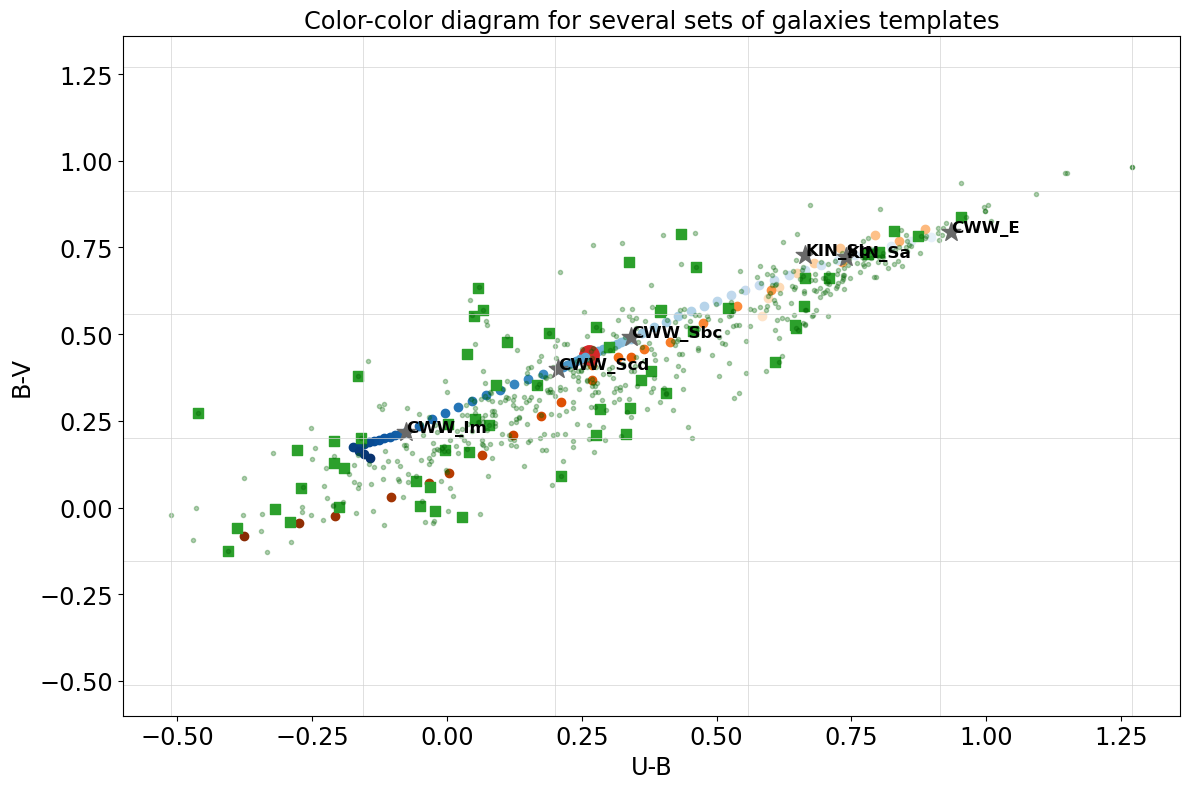

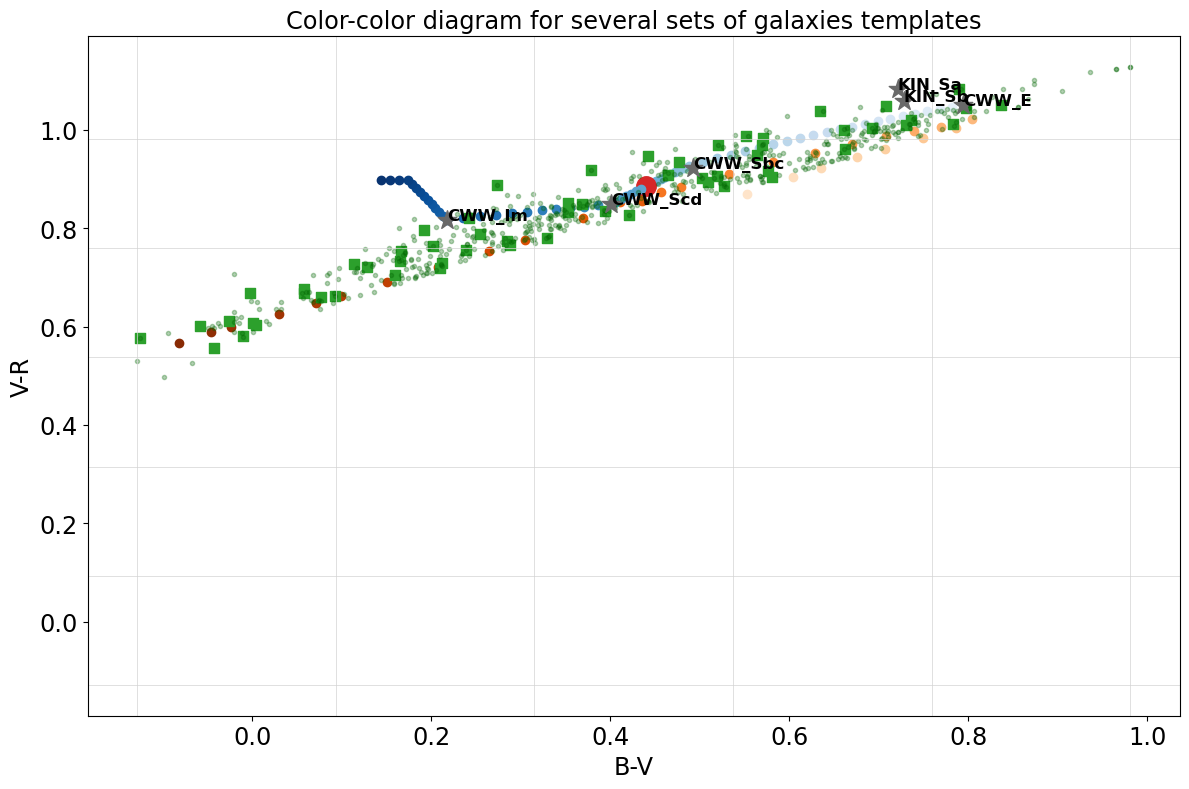

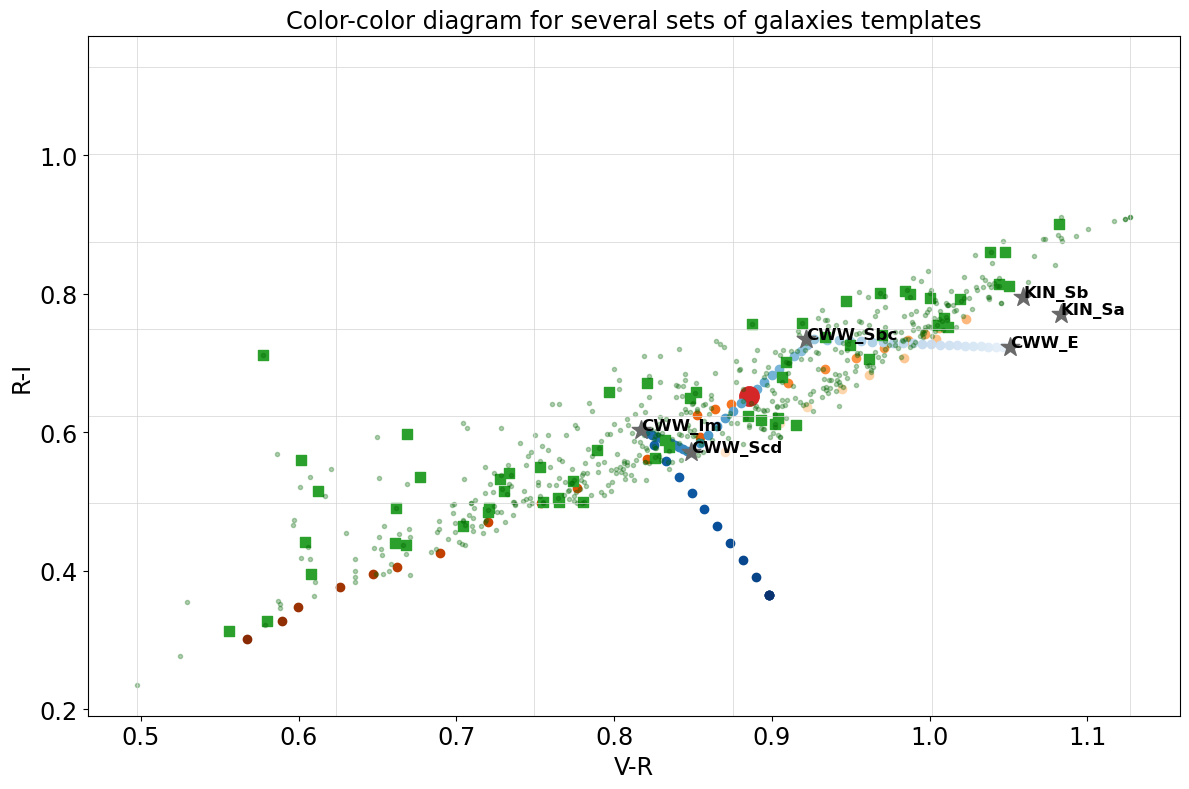

In [25]:
for _c1, _c2, _c3 in zip(mag_list[:-2], mag_list[1:-1], mag_list[2:]):
    f, a = plt.subplots(1,1)

    for _sed, col in zip(paths_to_vistas, all_oranges):
        _spec_arr = np.loadtxt(_sed)
        _spec_fonc = interp1d(_spec_arr[:-1, 0], _spec_arr[:-1, 1], bounds_error=False, fill_value=0.)
        _lumins = _spec_fonc(lambdas)
        _norm = np.trapz(_lumins[mask], lambdas[mask])
        normed_spec = _lumins/_norm
        col_UB = color_index(lambdas[mask], normed_spec[mask], rect_bands_dict[_c1], rect_bands_dict[_c2])
        col_BV = color_index(lambdas[mask], normed_spec[mask], rect_bands_dict[_c2], rect_bands_dict[_c3])
        a.scatter(col_UB, col_BV, color=col)
        
    for _sed, col in zip(paths_to_cfhs, all_blues):
        _spec_arr = np.loadtxt(_sed)
        _spec_fonc = interp1d(_spec_arr[:-1, 0], _spec_arr[:-1, 1], bounds_error=False, fill_value=0.)
        _lumins = _spec_fonc(lambdas)
        _norm = np.trapz(_lumins[mask], lambdas[mask])
        normed_spec = _lumins/_norm
        col_UB = color_index(lambdas[mask], normed_spec[mask], rect_bands_dict[_c1], rect_bands_dict[_c2])
        col_BV = color_index(lambdas[mask], normed_spec[mask], rect_bands_dict[_c2], rect_bands_dict[_c3])
        #print(_sed)
        if 'Sbc_cww.sed.resample9' in _sed:
            a.scatter(col_UB, col_BV, color='tab:red', s=196)
        else:
            a.scatter(col_UB, col_BV, color=col)
    
    if not use_average:
        _mask = df_fors2SL_prop["Selected"]
        a.scatter(x=df_fors2SL_prop[f'{_c1}-{_c2}'][_mask], y=df_fors2SL_prop[f'{_c2}-{_c3}'][_mask],\
                  color='tab:green', marker='s', s=49)
    else:
        for key in df_4D_col_avg.columns[1:]:
            _spec = df_4D_col_avg[key]
            col_x = color_index(df_4D_col_avg['Wavelength'], _spec, rect_bands_dict[_c1], rect_bands_dict[_c2])
            col_y = color_index(df_4D_col_avg['Wavelength'], _spec, rect_bands_dict[_c2], rect_bands_dict[_c3])
            a.scatter(x=col_x, y=col_y, color='tab:green', marker='s', s=49)
    
    a.scatter(x=df_fors2SL_prop[f'{_c1}-{_c2}'], y=df_fors2SL_prop[f'{_c2}-{_c3}'],\
              color='darkgreen', marker='o', s=9, alpha=0.3)
    for _x in bin_edges[f'binEdges_{_c1}-{_c2}']:
        a.axvline(x=_x, linewidth=0.5, color="lightgray")
    for _y in bin_edges[f'binEdges_{_c1}-{_c2}']:
        a.axhline(y=_y, linewidth=0.5, color="lightgray")
    
    #for _text, _x, _y in zip([ f'id{_num}' for _num in np.array(df_fors2SL_prop.index)[_mask] ],\
    #                         df_fors2SL_prop[f'{_c1}-{_c2}'][_mask],\
    #                         df_fors2SL_prop[f'{_c2}-{_c3}'][_mask] ):
    #    a.annotate(_text, (_x, _y), fontsize=12)

    for kin_sed in df_cww_spec_normed.columns[1:]:
        col_UB_cww = color_index(lambdas[mask], df_cww_spec_normed[kin_sed][mask], rect_bands_dict[_c1], rect_bands_dict[_c2])
        col_BV_cww = color_index(lambdas[mask], df_cww_spec_normed[kin_sed][mask], rect_bands_dict[_c2], rect_bands_dict[_c3])

        kin_name = "_".join(kin_sed.split('_')[:2])

        a.scatter(col_UB_cww, col_BV_cww, color='dimgray', s=196, marker="*")
        a.annotate(kin_name, (col_UB_cww, col_BV_cww), fontsize=12, weight='bold')

    #a.legend(loc='lower left', bbox_to_anchor=(1., 0.))

    a.set_xlabel(f"{_c1}-{_c2}")
    a.set_ylabel(f"{_c2}-{_c3}")
    a.set_title(f"Color-color diagram for several sets of galaxies templates")

    f.set_tight_layout(True)
    #all_figs_colors.append(f)

## 4. Now let's generate templates from this dictionary !

### Create SED files

In [26]:
_gal_seds = 'FORS2_ColorSelect_batch5'
sed_dir = os.path.join(LEPHAREDIR, 'sed/GAL', _gal_seds)
if not os.path.isdir(sed_dir) : os.makedirs(sed_dir)
list_file_name = f'SED_FORS2_ColorSelect_SL_v5'
if not use_average: _mask = df_fors2SL_prop["Selected"]

In [27]:
if True:
    with open(os.path.join(LEPHAREWORK, list_file_name+'.list'), 'w') as _l:
        _l.write(f'# FORS2-derived templates selected and averaged regarding their position in the 4D color space\n')
    if use_average:
        for _col in df_4D_col_avg.columns[1:]:
            _arr = np.column_stack((df_4D_col_avg['Wavelength'], df_4D_col_avg[_col]))
            np.savetxt(os.path.join(sed_dir,f'{_col}.sed'), _arr, fmt=('%10.1f', '%10.8f'), delimiter=" ")
            with open(os.path.join(LEPHAREWORK, list_file_name+'.list'), 'a') as _l:
                _l.write(_gal_seds+f'/{_col}.sed\n')
    else:
        for _spec in df_fors2SL_prop["Spectrum"][_mask]:
            _arr = np.column_stack((df_fors2SL_spec['Wavelength'], df_fors2SL_spec[_spec]))
            np.savetxt(os.path.join(sed_dir,f'{_spec}.sed'), _arr, fmt=('%10.1f', '%10.8f'), delimiter=" ")
            with open(os.path.join(LEPHAREWORK, list_file_name+'.list'), 'a') as _l:
                _l.write(_gal_seds+f'/{_spec}.sed\n')

In [28]:
if True:
    list_file_name = list_file_name+'_normed'
    with open(os.path.join(LEPHAREWORK, list_file_name+'.list'), 'w') as _l:
        _l.write(f'# FORS2-derived templates selected and averaged regarding their position in the 4D color space. Normalised by the integral between {lambdaMin} and {lambdaMax} angstrom.\n')
    if use_average:
        for _col in df_4D_col_avg_normed.columns[1:]:
            _arr = np.column_stack((df_4D_col_avg_normed['Wavelength'], df_4D_col_avg_normed[_col]))
            np.savetxt(os.path.join(sed_dir,f'{_col}.sed'), _arr, fmt=('%10.1f', '%10.8f'), delimiter=" ")
            with open(os.path.join(LEPHAREWORK, list_file_name+'.list'), 'a') as _l:
                _l.write(_gal_seds+f'/{_col}.sed\n')
    else:
        for _spec in df_fors2SL_prop["Normalized spectrum"][_mask]:
            _arr = np.column_stack((df_fors2SL_spec_normed['Wavelength'], df_fors2SL_spec_normed[_spec]))
            np.savetxt(os.path.join(sed_dir,f'{_spec}.sed'), _arr, fmt=('%10.1f', '%10.8f'), delimiter=" ")
            with open(os.path.join(LEPHAREWORK, list_file_name+'.list'), 'a') as _l:
                _l.write(_gal_seds+f'/{_spec}.sed\n')

In [29]:
sorted(os.listdir(sed_dir))

['AVG_UB-0.33_BV-0.02_VR0.56_RI0.30.sed',
 'AVG_UB-0.33_BV-0.02_VR0.56_RI0.30_norm.sed',
 'AVG_UB-0.33_BV-0.02_VR0.56_RI0.44.sed',
 'AVG_UB-0.33_BV-0.02_VR0.56_RI0.44_norm.sed',
 'AVG_UB-0.33_BV-0.02_VR0.56_RI0.57.sed',
 'AVG_UB-0.33_BV-0.02_VR0.56_RI0.57_norm.sed',
 'AVG_UB-0.33_BV-0.02_VR0.56_RI0.71.sed',
 'AVG_UB-0.33_BV-0.02_VR0.56_RI0.71_norm.sed',
 'AVG_UB-0.33_BV-0.02_VR0.69_RI0.44.sed',
 'AVG_UB-0.33_BV-0.02_VR0.69_RI0.44_norm.sed',
 'AVG_UB-0.33_BV-0.02_VR0.69_RI0.57.sed',
 'AVG_UB-0.33_BV-0.02_VR0.69_RI0.57_norm.sed',
 'AVG_UB-0.33_BV0.20_VR0.69_RI0.44.sed',
 'AVG_UB-0.33_BV0.20_VR0.69_RI0.44_norm.sed',
 'AVG_UB-0.33_BV0.20_VR0.69_RI0.57.sed',
 'AVG_UB-0.33_BV0.20_VR0.69_RI0.57_norm.sed',
 'AVG_UB-0.33_BV0.20_VR0.81_RI0.44.sed',
 'AVG_UB-0.33_BV0.20_VR0.81_RI0.44_norm.sed',
 'AVG_UB-0.33_BV0.20_VR0.81_RI0.57.sed',
 'AVG_UB-0.33_BV0.20_VR0.81_RI0.57_norm.sed',
 'AVG_UB-0.33_BV0.20_VR0.81_RI0.71.sed',
 'AVG_UB-0.33_BV0.20_VR0.81_RI0.71_norm.sed',
 'AVG_UB-0.33_BV0.20_VR0.94_RI0

In [30]:
len(sorted(os.listdir(sed_dir)))

118